# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import importlib


from BitcoinModeler import *


# Bitcoin Price Prediction

This notebook trains simple linear models for BTC price horizons **H1** and **H7**, evaluates them on **Train/Validation/Test**, plots performance


## 🧱 Data & Splits

We load preprocessed CSVs for both horizons:

- **Train**: used to fit model parameters  
- **Validation (val)**: used to choose models/hyperparameters (no peeking at Test)  
- **Test**: used once at the end for an unbiased performance estimate




In [2]:
# Load h1 data
h1_train = pd.read_csv('../data/processed/h1_vif_train.csv')
h1_val = pd.read_csv('../data/processed/h1_vif_val.csv')
h1_test = pd.read_csv('../data/processed/h1_vif_test.csv')

# Load h7 data
h7_train = pd.read_csv('../data/processed/h7_vif_train.csv')
h7_val = pd.read_csv('../data/processed/h7_vif_val.csv')
h7_test = pd.read_csv('../data/processed/h7_vif_test.csv')

print(f"H1 - Train: {h1_train.shape}, Val: {h1_val.shape}, Test: {h1_test.shape}")
print(f"H7 - Train: {h7_train.shape}, Val: {h7_val.shape}, Test: {h7_test.shape}")

H1 - Train: (1877, 45), Val: (402, 45), Test: (403, 45)
H7 - Train: (1873, 45), Val: (401, 45), Test: (402, 45)


In [3]:
bundle_h1=DataManager.prepare(h1_train, h1_val, h1_test, "y_btc_close_t+1","H1")
bundle_h7=DataManager.prepare(h7_train, h7_val, h7_test, "y_btc_close_t+7","H7")

> Note: Features are **already z-score normalized using train-only stats** in `split.py` to avoid leakage.

In [4]:
# optional if you want to compare scaled vs unscaled 
#scaler_h1_cls = ScalerManager()
#bundle_h1_scaled = scaler_h1_cls.scale_bundle(bundle_h1)

#scaler_h7_cls = ScalerManager()
#bundle_h7_scaled = scaler_h7_cls.scale_bundle(bundle_h7)
#print("Class-based DataBundle objects created (both raw and scaled variants).")


## 🚀 Model Runs

We fit all three models on **H1 (1-day)** and **H7 (7-day)** horizons, then print per-split metrics.


In [5]:
# === Run experiments
runner_h1 = ExperimentRunner(bundle_h1, scaled=True)
df_h1 = runner_h1.run()

runner_h7 = ExperimentRunner(bundle_h7, scaled=True)
df_h7 = runner_h7.run()

#runner_h1s = ExperimentRunner(bundle_h1_scaled, scaled=True)
#df_h1s = runner_h1s.run()

#runner_h7s = ExperimentRunner(bundle_h7_scaled, scaled=True)
#df_h7s = runner_h7s.run()



## 📊 Results Table (All Models × Splits)


In [6]:

# Merge all for a single summary table 
results_df_classes = pd.concat([df_h1, df_h7], ignore_index=True)
print("\n——— CLASS-BASED RESULTS SUMMARY ———")
print(results_df_classes.to_string(index=False, float_format="%.6f"))


——— CLASS-BASED RESULTS SUMMARY ———
Horizon Scaled?  Model    Dataset            MSE        RMSE         MAE       R2
     H1     Yes Linear Validation   10439.326656  102.173023   85.534415 0.541819
     H1     Yes Linear       Test 3200286.527118 1788.934467 1209.304850 0.849749
     H1     Yes  Ridge Validation   10296.745592  101.472881   84.951278 0.548077
     H1     Yes  Ridge       Test 3197531.419422 1788.164260 1207.528985 0.849878
     H1     Yes  Lasso Validation   10450.137597  102.225915   85.673291 0.541344
     H1     Yes  Lasso       Test 3212752.580802 1792.415293 1211.787399 0.849163
     H7     Yes Linear Validation    9089.640787   95.339608   68.337234 0.602516
     H7     Yes Linear       Test 4051549.276089 2012.846064 1095.865828 0.809857
     H7     Yes  Ridge Validation    8963.347551   94.674957   67.730576 0.608039
     H7     Yes  Ridge       Test 4046160.817525 2011.507101 1094.010242 0.810110
     H7     Yes  Lasso Validation    9069.803624   95.235517 

In [7]:


# Feature importance for Lasso models

lasso_h1 = [m for m in runner_h1.models if m.name == "Lasso"][0]
lasso_h7 = [m for m in runner_h7.models if m.name == "Lasso"][0]
H1ModelWrap=ModelWrapper("H1",lasso_h1.model)
H7ModelWrap=ModelWrapper("H7",lasso_h7.model)



## 📈 Lasso Performance — Validation vs Test

The chart below compares **Nonzero** vs **Zero**  for each horizon (H1, H7).  



Feature Importance Analysis


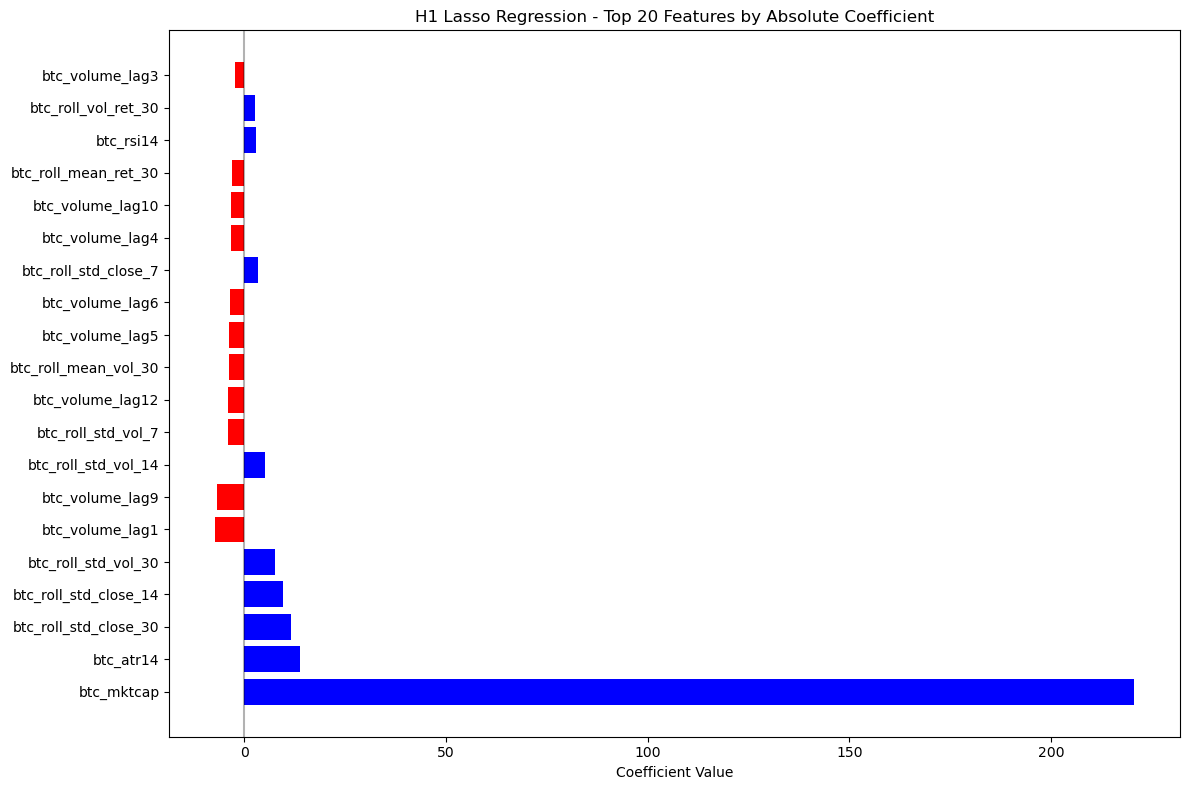

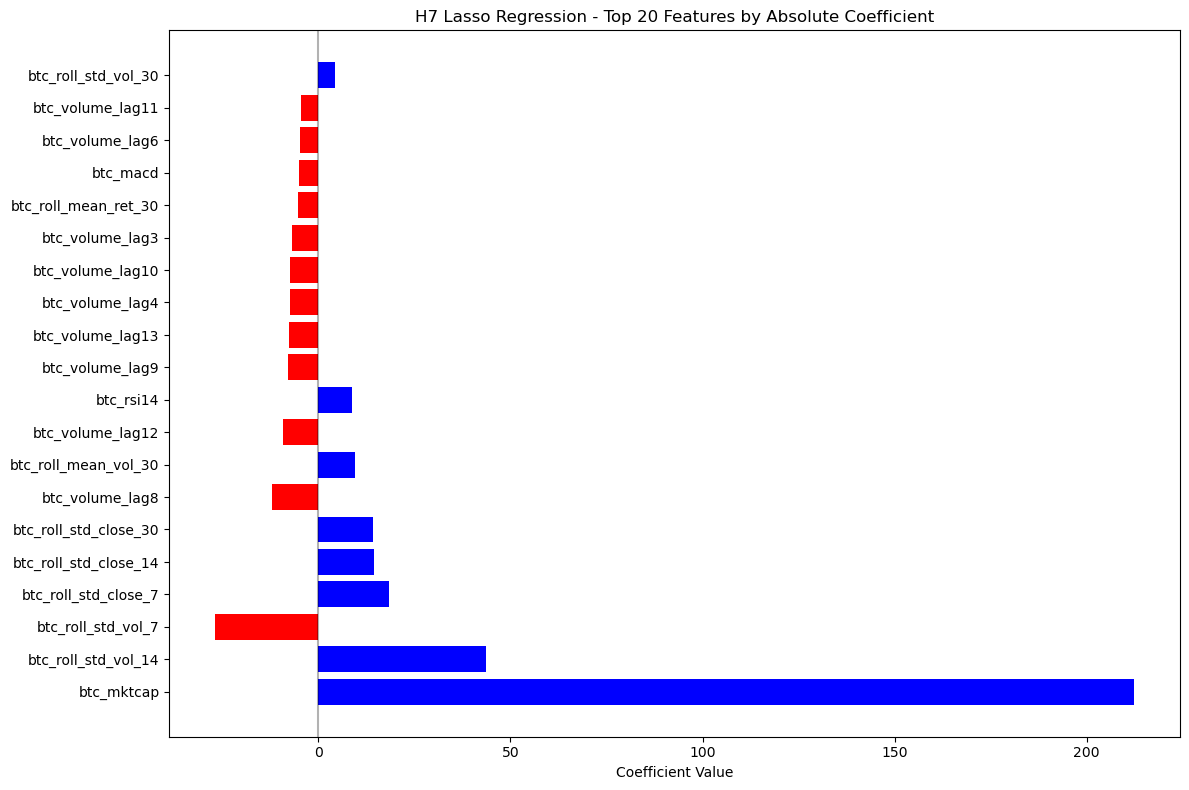

In [8]:
print("Feature Importance Analysis")
print("="*50)
# H1 Lasso
h1_lasso_features = H1ModelWrap.plot_feature_importance(bundle_h1.feature_cols, 'H1 Lasso Regression')
# H7 Lasso  
h7_lasso_features = H7ModelWrap.plot_feature_importance(bundle_h7.feature_cols, 'H7 Lasso Regression')

## 🏆 Best Model Summary (Chosen by Validation RMSE)

For **each horizon**, we pick the model  with the **lowest Validation RMSE**, then report its **R2** and **Test_MSE** metrics.  



In [9]:
# -- Produce and print the best-model summary (pick by Validation RMSE; show Test metrics)
best_summary = ModelWrapper.best_summary(results_df_classes, metric="RMSE", prefer_scaled=None)
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown")
print("="*80)
print(best_summary.to_string(index=False, float_format="%.6f"))
print("\n" + "="*80)
print("BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown")
print("="*80)
best_summaryR2 = ModelWrapper.best_summary(results_df_classes, metric="R2", prefer_scaled=None)
print(best_summaryR2.to_string(index=False, float_format="%.6f"))

H1LassoNonZeroCoef=H1ModelWrap.get_lasso_nonzero_coef(bundle_h1.feature_cols)
H7LassoNonZeroCoef=H7ModelWrap.get_lasso_nonzero_coef(bundle_h1.feature_cols)
result = (
    f"H1: {H1LassoNonZeroCoef}/{len(bundle_h1.feature_cols)} features selected | "
    f"H7: {H7LassoNonZeroCoef}/{len(bundle_h7.feature_cols)} features selected"
)
print(result)




BEST MODEL SUMMARY — picked by lowest Validation RMSE; Test metrics shown
Horizon Model Scaled?   Val_RMSE            MSE        RMSE         MAE       R2
     H1 Ridge     Yes 101.472881 3197531.419422 1788.164260 1207.528985 0.849878
     H7 Ridge     Yes  94.674957 4046160.817525 2011.507101 1094.010242 0.810110

BEST MODEL SUMMARY — picked by lowest Validation R2; Test metrics shown
Horizon Model Scaled?   Val_R2            MSE        RMSE         MAE       R2
     H1 Ridge     Yes 0.548077 3197531.419422 1788.164260 1207.528985 0.849878
     H7 Ridge     Yes 0.608039 4046160.817525 2011.507101 1094.010242 0.810110
H1: 42/43 features selected | H7: 43/43 features selected


## 🧭 Baselines & Diagnostics 
  1. Compare model performance across different prediction timeframes
  2. Regularization effects of Ridge vs Lasso regression
  3. Feature selection capabilities of Lasso regression
  4. Model stability across validation and test sets
